# LeNet-5 CNN: LARS optimizer + LR Scheduler - MNIST & PyTorch


LARS optimizer was introduced by Yang You et al. in [Large Batch Training of Convolutional Networks](https://arxiv.org/abs/1708.03888)

Layer-wise Adaptive Rate Scaling, or LARS, is a large batch optimization technique. There are two notable differences between LARS and other adaptive algorithms such as Adam or RMSProp:
1. first, LARS uses a separate learning rate for each layer and not for each weight.
2. And second, the magnitude of the update is controlled with respect to the weight norm for better control of training speed.

_Learning Rate Scheduler:_

- linear warmup
- cosine decay (without warm restart(s))


References

- [apex LARS optimizer](https://github.com/NVIDIA/apex/blob/master/apex/parallel/LARC.py)
- [SwAV official GitHub repo](https://github.com/facebookresearch/swav/blob/main/main_swav.py)
- [LARS explained](https://paperswithcode.com/method/lars)

In [ ]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
# %env CUDA_VISIBLE_DEVICES = 0, 1, 2, 3
%env CUDA_VISIBLE_DEVICES = 0, 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from LARC import LARC

from models.LeNet5_CNN_torch import LeNet5, init_weights

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 2.1.1+cpu
Number of GPU(s) available = 0
PyTorch does not have access to GPU
Available device is cpu


In [3]:
# Hyper-parameters-
num_train_epochs = 50
warmup_epochs = 10
batch_size = 1024

# learning_rate = 0.001
base_lr = 0.6
final_lr = 0.0006

In [4]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [5]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
    root = '/home/amajumdar/Downloads/.data/', train = True,
    transform = transforms_apply, download = True
)

test_dataset = torchvision.datasets.MNIST(
    root = "/home/amajumdar/Downloads/.data/", train = False,
    transform = transforms_apply
)

In [6]:
len(train_dataset.targets), len(train_dataset.data)

(60000, 60000)

In [7]:
len(test_dataset.targets), len(test_dataset.data)

(10000, 10000)

In [8]:
print(f"training dataset length/shape: {list(train_dataset.data.size())}")

training dataset length/shape: [60000, 28, 28]


In [9]:
print(f"mean = {train_dataset.data.float().mean() / 255:.4f} &"
      f"std dev = {train_dataset.data.float().std() / 255:.4f}"
     )

mean = 0.1307 &std dev = 0.3081


In [10]:
train_dataset_size = len(train_dataset.data)

# number of steps per epoch-
num_steps_epoch = int(np.round(train_dataset_size / batch_size))

In [11]:
print(f"train dataset size = {train_dataset_size} & # of steps per epoch = {num_steps_epoch}")

train dataset size = 60000 & # of steps per epoch = 59


In [12]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = False
)

In [13]:
# Get some random batch of training images & labels-
images, labels = next(iter(train_loader))
print(f"images.shape: {images.shape}")

# De-normalize the batch of images-
images *= 255.0

images.shape: torch.Size([256, 1, 28, 28])


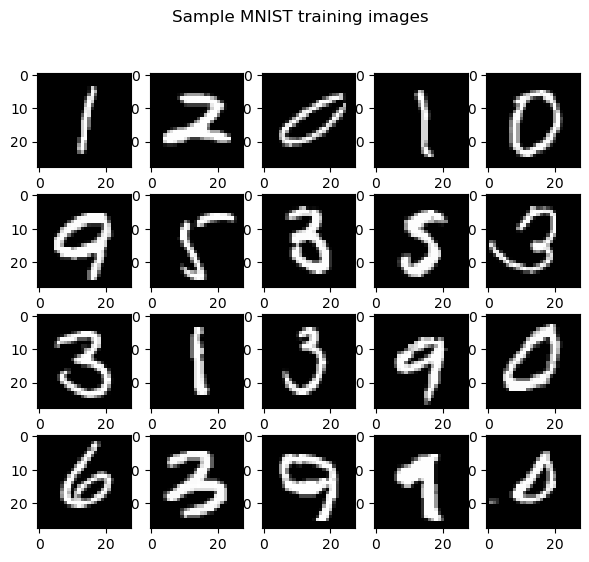

In [14]:
# Visualize 20 images from training set-
plt.figure(figsize = (7, 6))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

In [15]:
del images, labels

In [13]:
# Initialize an instance of LeNet-5 CNN architecture-
model = LeNet5(beta = 1.0)

# Apply weights initialization-
model.apply(init_weights)

# Save randomly inialize parameters-
# torch.save(model.state_dict(), "LeNet5_random_params.pth")

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
# Push to GPU (if available)-
model = model.to(device)

In [15]:
# Define cost function-
loss_fn = nn.CrossEntropyLoss()

In [16]:
# Define optimizer-
optimizer = torch.optim.SGD(
    params = model.parameters(),
    lr = 0.0, momentum = 0.9,
    weight_decay = 5e-4,
)

optimizer = LARC(
    optimizer = optimizer, trust_coefficient = 0.001,
    clip = False
)

### Learning Rate Scheduler

- linear learning rate warmup
- cosine annealing without warm restart(s)

In [17]:
# Linear lr warmup-
warmup_lr_schedule = np.linspace(start = 0, stop = base_lr, num = num_steps_epoch * warmup_epochs, endpoint = True)

In [18]:
def cosine_annealing(t, eta, T):
    return 0.5 * (1 + np.cos((t * np.pi) / T)) * eta

In [19]:
cosine_lr_scheduler = [cosine_annealing(t = t, eta = base_lr, T = (num_train_epochs - warmup_epochs) * num_steps_epoch) for t in range(1, ((num_train_epochs - warmup_epochs) * num_steps_epoch) + 1)]

In [20]:
lr_scheduler = np.concatenate((warmup_lr_schedule, cosine_lr_scheduler))

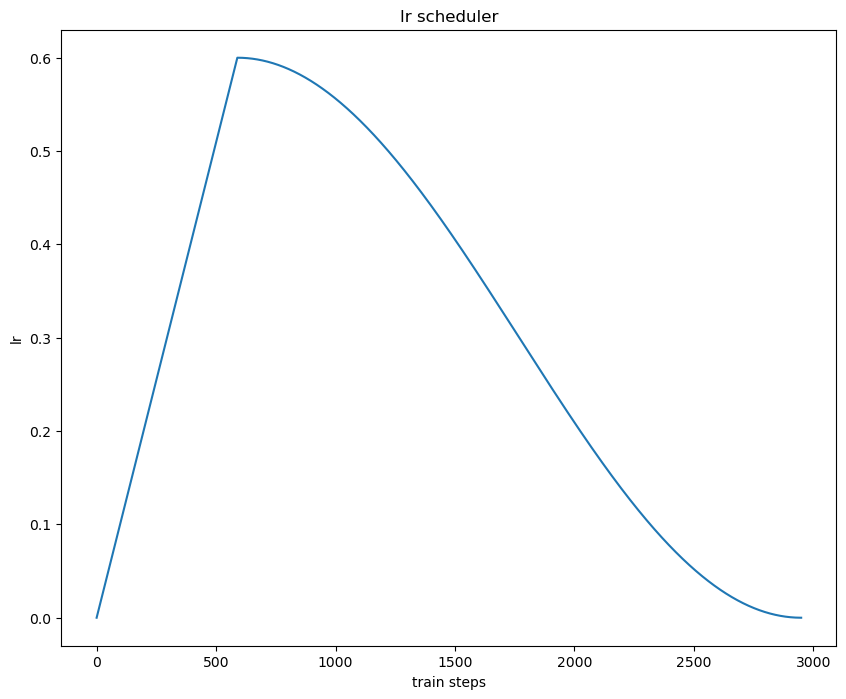

In [21]:
# Visualize lr scheduler-
plt.figure(figsize = (10, 8))
plt.plot(lr_scheduler)
plt.xlabel("train steps")
plt.ylabel("lr")
plt.title("lr scheduler")
plt.show()

In [22]:
step = 0

In [23]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss_fn(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()

            # Update LR scheduler & LARS params-
            global step
            # optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_scheduler[step]
            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [24]:
def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss_fn(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [25]:
# Python3 dict to contain training metrics-
training_history = {}

# Initialize parameters saving 'best' models-
best_val_acc = 0

In [26]:
for epoch in range(num_train_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}%"
          f" & LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "LeNet5_best_model.pth")
         

Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58batch/s, val_acc=33.2, val_loss=1.91]



epoch: 1 training loss = 2.3736, training accuracy = 17.61%, val_loss = 1.9092, val_accuracy = 33.17% & LR = 0.0591

Saving model with highest val_acc = 33.1700%



Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23batch/s, val_acc=81, val_loss=0.853]



epoch: 2 training loss = 1.3951, training accuracy = 57.83%, val_loss = 0.8528, val_accuracy = 81.01% & LR = 0.1192

Saving model with highest val_acc = 81.0100%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20batch/s, val_acc=91.7, val_loss=0.35]



epoch: 3 training loss = 0.6033, training accuracy = 86.49%, val_loss = 0.3496, val_accuracy = 91.70% & LR = 0.1793

Saving model with highest val_acc = 91.7000%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41batch/s, val_acc=95.2, val_loss=0.181]



epoch: 4 training loss = 0.2708, training accuracy = 93.15%, val_loss = 0.1806, val_accuracy = 95.24% & LR = 0.2394

Saving model with highest val_acc = 95.2400%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11batch/s, val_acc=96.9, val_loss=0.114]



epoch: 5 training loss = 0.1509, training accuracy = 95.89%, val_loss = 0.1136, val_accuracy = 96.94% & LR = 0.2995

Saving model with highest val_acc = 96.9400%



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.00batch/s, val_acc=97.4, val_loss=0.0847]



epoch: 6 training loss = 0.1022, training accuracy = 97.10%, val_loss = 0.0847, val_accuracy = 97.43% & LR = 0.3596

Saving model with highest val_acc = 97.4300%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.84batch/s, val_acc=98, val_loss=0.0666]



epoch: 7 training loss = 0.0769, training accuracy = 97.81%, val_loss = 0.0666, val_accuracy = 98.02% & LR = 0.4197

Saving model with highest val_acc = 98.0200%



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11batch/s, val_acc=98.4, val_loss=0.0573]



epoch: 8 training loss = 0.0617, training accuracy = 98.20%, val_loss = 0.0573, val_accuracy = 98.40% & LR = 0.4798

Saving model with highest val_acc = 98.4000%



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.88batch/s, val_acc=98.5, val_loss=0.0521]



epoch: 9 training loss = 0.0514, training accuracy = 98.56%, val_loss = 0.0521, val_accuracy = 98.46% & LR = 0.5399

Saving model with highest val_acc = 98.4600%



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66batch/s, val_acc=98.7, val_loss=0.0452]



epoch: 10 training loss = 0.0441, training accuracy = 98.70%, val_loss = 0.0452, val_accuracy = 98.67% & LR = 0.6000

Saving model with highest val_acc = 98.6700%



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.43batch/s, val_acc=98.7, val_loss=0.0445]



epoch: 11 training loss = 0.0379, training accuracy = 98.97%, val_loss = 0.0445, val_accuracy = 98.68% & LR = 0.5991

Saving model with highest val_acc = 98.6800%



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20batch/s, val_acc=98.8, val_loss=0.0407]



epoch: 12 training loss = 0.0328, training accuracy = 99.09%, val_loss = 0.0407, val_accuracy = 98.75% & LR = 0.5963

Saving model with highest val_acc = 98.7500%



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.46batch/s, val_acc=98.5, val_loss=0.0423]



epoch: 13 training loss = 0.0288, training accuracy = 99.25%, val_loss = 0.0423, val_accuracy = 98.54% & LR = 0.5917



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97batch/s, val_acc=98.9, val_loss=0.036]



epoch: 14 training loss = 0.0258, training accuracy = 99.36%, val_loss = 0.0360, val_accuracy = 98.90% & LR = 0.5853

Saving model with highest val_acc = 98.9000%



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.51batch/s, val_acc=98.9, val_loss=0.0341]



epoch: 15 training loss = 0.0229, training accuracy = 99.45%, val_loss = 0.0341, val_accuracy = 98.87% & LR = 0.5772



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.42batch/s, val_acc=98.9, val_loss=0.0341]



epoch: 16 training loss = 0.0212, training accuracy = 99.49%, val_loss = 0.0341, val_accuracy = 98.93% & LR = 0.5673

Saving model with highest val_acc = 98.9300%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38batch/s, val_acc=98.9, val_loss=0.035]



epoch: 17 training loss = 0.0203, training accuracy = 99.52%, val_loss = 0.0350, val_accuracy = 98.87% & LR = 0.5558



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.62batch/s, val_acc=99, val_loss=0.0322]



epoch: 18 training loss = 0.0179, training accuracy = 99.62%, val_loss = 0.0322, val_accuracy = 98.95% & LR = 0.5427

Saving model with highest val_acc = 98.9500%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.49batch/s, val_acc=99.1, val_loss=0.031]



epoch: 19 training loss = 0.0167, training accuracy = 99.64%, val_loss = 0.0310, val_accuracy = 99.05% & LR = 0.5281

Saving model with highest val_acc = 99.0500%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.46batch/s, val_acc=99, val_loss=0.0316]



epoch: 20 training loss = 0.0156, training accuracy = 99.69%, val_loss = 0.0316, val_accuracy = 98.98% & LR = 0.5121



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.40batch/s, val_acc=99.1, val_loss=0.0322]



epoch: 21 training loss = 0.0147, training accuracy = 99.70%, val_loss = 0.0322, val_accuracy = 99.05% & LR = 0.4948



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.47batch/s, val_acc=99, val_loss=0.0321]



epoch: 22 training loss = 0.0136, training accuracy = 99.76%, val_loss = 0.0321, val_accuracy = 98.97% & LR = 0.4763



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.52batch/s, val_acc=99, val_loss=0.0311]



epoch: 23 training loss = 0.0130, training accuracy = 99.77%, val_loss = 0.0311, val_accuracy = 98.95% & LR = 0.4567



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08batch/s, val_acc=99.1, val_loss=0.029]



epoch: 24 training loss = 0.0125, training accuracy = 99.80%, val_loss = 0.0290, val_accuracy = 99.13% & LR = 0.4362

Saving model with highest val_acc = 99.1300%



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.55batch/s, val_acc=99.2, val_loss=0.0292]



epoch: 25 training loss = 0.0118, training accuracy = 99.81%, val_loss = 0.0292, val_accuracy = 99.15% & LR = 0.4148

Saving model with highest val_acc = 99.1500%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.39batch/s, val_acc=99, val_loss=0.0316]



epoch: 26 training loss = 0.0112, training accuracy = 99.83%, val_loss = 0.0316, val_accuracy = 99.03% & LR = 0.3927



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.48batch/s, val_acc=99.1, val_loss=0.0295]



epoch: 27 training loss = 0.0109, training accuracy = 99.84%, val_loss = 0.0295, val_accuracy = 99.13% & LR = 0.3700



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.51batch/s, val_acc=99.1, val_loss=0.0294]



epoch: 28 training loss = 0.0104, training accuracy = 99.86%, val_loss = 0.0294, val_accuracy = 99.06% & LR = 0.3469



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.25batch/s, val_acc=99.1, val_loss=0.0295]



epoch: 29 training loss = 0.0098, training accuracy = 99.87%, val_loss = 0.0295, val_accuracy = 99.09% & LR = 0.3235



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.35batch/s, val_acc=99.1, val_loss=0.0294]



epoch: 30 training loss = 0.0096, training accuracy = 99.89%, val_loss = 0.0294, val_accuracy = 99.09% & LR = 0.3000



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.36batch/s, val_acc=99.1, val_loss=0.0291]



epoch: 31 training loss = 0.0095, training accuracy = 99.89%, val_loss = 0.0291, val_accuracy = 99.12% & LR = 0.2765



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.40batch/s, val_acc=99.2, val_loss=0.0287]



epoch: 32 training loss = 0.0089, training accuracy = 99.89%, val_loss = 0.0287, val_accuracy = 99.18% & LR = 0.2531

Saving model with highest val_acc = 99.1800%



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.56batch/s, val_acc=99.2, val_loss=0.0282]



epoch: 33 training loss = 0.0086, training accuracy = 99.91%, val_loss = 0.0282, val_accuracy = 99.16% & LR = 0.2300



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18batch/s, val_acc=99.1, val_loss=0.0291]



epoch: 34 training loss = 0.0084, training accuracy = 99.92%, val_loss = 0.0291, val_accuracy = 99.13% & LR = 0.2073



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.95batch/s, val_acc=99.2, val_loss=0.0279]



epoch: 35 training loss = 0.0080, training accuracy = 99.94%, val_loss = 0.0279, val_accuracy = 99.16% & LR = 0.1852



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02batch/s, val_acc=99.1, val_loss=0.029]



epoch: 36 training loss = 0.0080, training accuracy = 99.93%, val_loss = 0.0290, val_accuracy = 99.14% & LR = 0.1638



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04batch/s, val_acc=99.2, val_loss=0.0284]



epoch: 37 training loss = 0.0077, training accuracy = 99.95%, val_loss = 0.0284, val_accuracy = 99.15% & LR = 0.1433



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89batch/s, val_acc=99.2, val_loss=0.0281]



epoch: 38 training loss = 0.0076, training accuracy = 99.94%, val_loss = 0.0281, val_accuracy = 99.16% & LR = 0.1237



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.95batch/s, val_acc=99.2, val_loss=0.0278]



epoch: 39 training loss = 0.0075, training accuracy = 99.95%, val_loss = 0.0278, val_accuracy = 99.15% & LR = 0.1052



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.98batch/s, val_acc=99.2, val_loss=0.0276]



epoch: 40 training loss = 0.0076, training accuracy = 99.95%, val_loss = 0.0276, val_accuracy = 99.19% & LR = 0.0879

Saving model with highest val_acc = 99.1900%



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15batch/s, val_acc=99.2, val_loss=0.0281]



epoch: 41 training loss = 0.0073, training accuracy = 99.95%, val_loss = 0.0281, val_accuracy = 99.18% & LR = 0.0719



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.40batch/s, val_acc=99.2, val_loss=0.028]



epoch: 42 training loss = 0.0072, training accuracy = 99.95%, val_loss = 0.0280, val_accuracy = 99.22% & LR = 0.0573

Saving model with highest val_acc = 99.2200%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12batch/s, val_acc=99.2, val_loss=0.028]



epoch: 43 training loss = 0.0071, training accuracy = 99.96%, val_loss = 0.0280, val_accuracy = 99.21% & LR = 0.0442



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.74batch/s, val_acc=99.2, val_loss=0.0279]



epoch: 44 training loss = 0.0070, training accuracy = 99.95%, val_loss = 0.0279, val_accuracy = 99.21% & LR = 0.0327



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62batch/s, val_acc=99.2, val_loss=0.0278]



epoch: 45 training loss = 0.0069, training accuracy = 99.96%, val_loss = 0.0278, val_accuracy = 99.21% & LR = 0.0228



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13batch/s, val_acc=99.2, val_loss=0.0277]



epoch: 46 training loss = 0.0069, training accuracy = 99.96%, val_loss = 0.0277, val_accuracy = 99.21% & LR = 0.0147



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.00batch/s, val_acc=99.2, val_loss=0.0278]



epoch: 47 training loss = 0.0069, training accuracy = 99.97%, val_loss = 0.0278, val_accuracy = 99.19% & LR = 0.0083



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.14batch/s, val_acc=99.2, val_loss=0.0278]



epoch: 48 training loss = 0.0068, training accuracy = 99.96%, val_loss = 0.0278, val_accuracy = 99.19% & LR = 0.0037



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23batch/s, val_acc=99.2, val_loss=0.0279]



epoch: 49 training loss = 0.0067, training accuracy = 99.96%, val_loss = 0.0279, val_accuracy = 99.19% & LR = 0.0009



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.90batch/s, val_acc=99.2, val_loss=0.0279]


epoch: 50 training loss = 0.0067, training accuracy = 99.97%, val_loss = 0.0279, val_accuracy = 99.20% & LR = 0.0000



In [27]:
# Save training metrics as Python3 history for later analysis-
with open("LeNet5_swish_LARS-training_history.pkl", "wb") as file:
    pickle.dump(training_history, file)

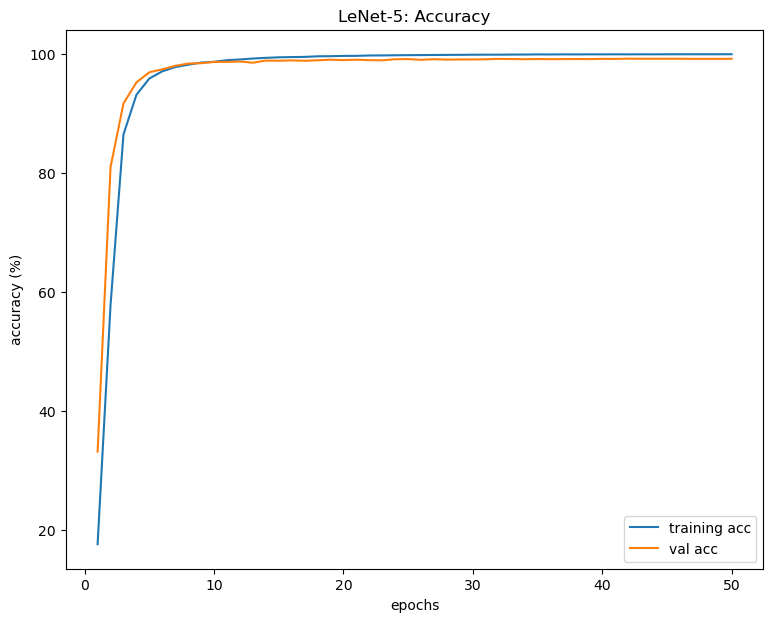

In [28]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history.keys()), [training_history[k]['acc'] for k in training_history.keys()], label = 'training acc')
plt.plot(list(training_history.keys()), [training_history[k]['val_acc'] for k in training_history.keys()], label = 'val acc')
plt.title("LeNet-5: Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

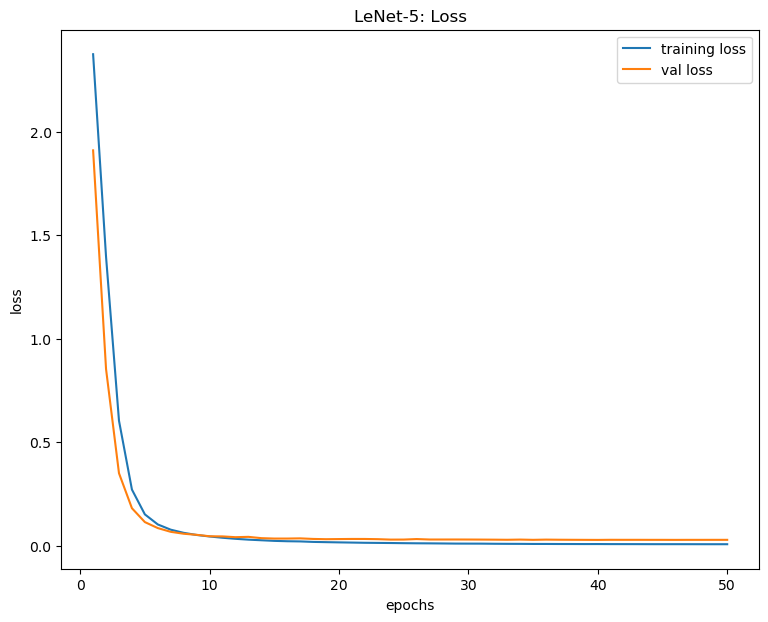

In [29]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history.keys()), [training_history[k]['loss'] for k in training_history.keys()], label = 'training loss')
plt.plot(list(training_history.keys()), [training_history[k]['val_loss'] for k in training_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("LeNet-5: Loss")
plt.show()

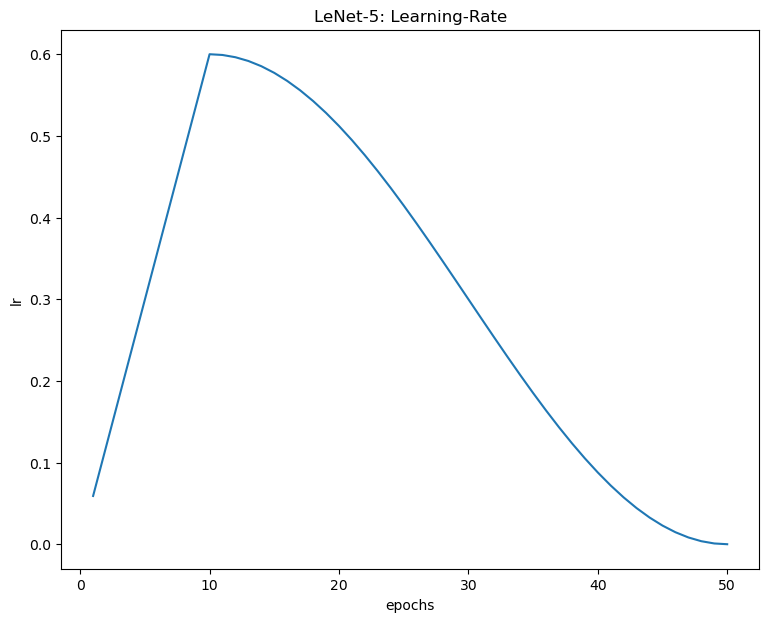

In [30]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history.keys()), [training_history[k]['lr'] for k in training_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LeNet-5: Learning-Rate")
plt.show()

In [31]:
# Last 5 lr values-
[training_history[k]['lr'] for k in training_history.keys()][-5:]

[0.01468304511145394,
 0.008289023880697032,
 0.003693497821458702,
 0.0009247998800616108,
 0.0]

In [32]:
# First 5 lr values-
[training_history[k]['lr'] for k in training_history.keys()][:5]

[0.05908319185059423,
 0.11918505942275041,
 0.17928692699490661,
 0.2393887945670628,
 0.299490662139219]

In [33]:
# Save LARS optimizer-
torch.save(optimizer.state_dict(), 'LeNet5_bestmodel_swish_lrscheduler_LARS_optim.pth')

In [34]:
optimizer.state_dict().keys()

dict_keys(['state', 'param_groups'])

In [35]:
optimizer.state_dict()['state'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [36]:
optimizer.state_dict()['param_groups'][0].keys()

dict_keys(['lr', 'momentum', 'dampening', 'weight_decay', 'nesterov', 'maximize', 'foreach', 'differentiable', 'params'])

In [37]:
optimizer.state_dict()['param_groups'][0]

{'lr': 0.0,
 'momentum': 0.9,
 'dampening': 0,
 'weight_decay': 0.0005,
 'nesterov': False,
 'maximize': False,
 'foreach': None,
 'differentiable': False,
 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}

In [38]:
optimizer.state_dict()['param_groups'][0]['params']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [39]:
optimizer.state_dict()['state'][0].keys()

dict_keys(['momentum_buffer'])